**Insper**  
**Redes Sociais**

# Projeto:<br/>Best Books Ever

**Jorás Oliveira**  
**Luciano Dias**  
**Tiago Seixas**


In [ ]:
!pip install scikit-learn

In [2]:
import sys
import re
import random
import math
import itertools

import netpixi
from ast import literal_eval
import seaborn as sns
from graph_tool import centrality, spectral, clustering
from matplotlib import pyplot as plt
from netpixi.integration.gt import *
from regression.integration.gt import *
import numpy as np
import pandas as pd
import regression as reg
from sklearn.preprocessing import minmax_scale

np.random.seed(27)

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


In [42]:
df = pd.read_csv("books_1.Best_Books_Ever.csv", usecols=["rating", "language", "genres"])

df['rating'] = minmax_scale(df['rating'])
df['language'] = df['language'].astype("category")
df['genres'] = df['genres'].apply(literal_eval)

df

,rating,language,genres
0,0.866,English,"[Young Adult, Fiction, Dystopia, Fantasy, Scie..."
1,0.900,English,"[Fantasy, Young Adult, Fiction, Magic, Childre..."
2,0.856,English,"[Classics, Fiction, Historical Fiction, School..."
3,0.852,English,"[Classics, Fiction, Romance, Historical Fictio..."
4,0.720,English,"[Young Adult, Fantasy, Romance, Vampires, Fict..."
...,...,...,...
52473,0.800,English,"[Vampires, Paranormal, Young Adult, Romance, F..."
52474,0.838,English,"[Mystery, Young Adult]"
52475,0.740,English,"[Fantasy, Young Adult, Paranormal, Angels, Rom..."
52476,0.770,English,"[Fiction, Mystery, Historical Fiction, Adventu..."


## 1. Construção da rede

In [43]:
SAMPLE_SIZE = 500

sample = df.sample(SAMPLE_SIZE, replace=False)

g = Graph(directed=False) # não dirigido
g.add_vp('rating')
g.add_ep('weight')


### 1.1. Operacionalização dos Vertices

In [44]:
for index, row in sample.iterrows():
    vertex = g.add_vertex(index)
    vertex["rating"] = row["rating"]


In [45]:
n = g.num_vertices()

f"{n} vertices na rede."

'500 vertices na rede.'

#### 1.1.1 Histograma de pesos dos vértices

<AxesSubplot: xlabel='rating', ylabel='Count'>

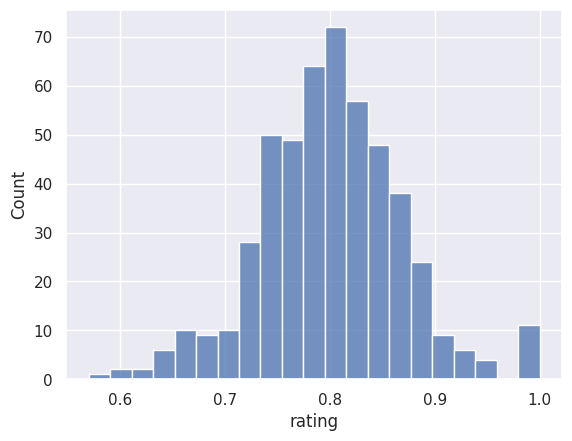

In [46]:
sns.histplot(sample["rating"])

### 1.2. Operacionalização das Arestas

In [47]:
max_edges = n * (n - 1)

f"{max_edges} arestas possíveis."

'249500 arestas possíveis.'

In [48]:
def get_weight(g1, r1, g2, r2):
    inter, i1, i2 = np.intersect1d(g1, g2, return_indices=True)
   
    if len(inter) == 0:
        return 0.0
   
    return np.sqrt(r1 * r2) * np.power((
        sum((
                (len(g1) - i1) + (len(g2) - i2)
            ) / (len(g1) + len(g2))
        ) / len(inter)
    ), 1 / len(inter))


In [49]:
combinations = itertools.combinations(sample.index, 2)
weights = []

for index, (id_1, id_2) in enumerate(combinations):
    row_1 = sample.loc[id_1]
    row_2 = sample.loc[id_2]
    weight = get_weight(row_1["genres"], row_1["rating"], row_2["genres"], row_2["rating"])

    if weight > 0.1:
        edge = g.add_edge(id_1, id_2)
        edge["weight"] = weight

        weights.append(weight)

    if (index*2) % 1_000 == 0:
        print(f"\r{index*2} {(index*200)//max_edges}%", end="")
        
print(f"\r{max_edges} 100%")


249500 100%


In [50]:
m = g.num_edges()

f"{m} arestas na rede. Densidade de {m/max_edges:.5f}"

'72058 arestas na rede. Densidade de 0.28881'

#### 1.2.1 Histograma de pessos das arestas

<AxesSubplot: ylabel='Count'>

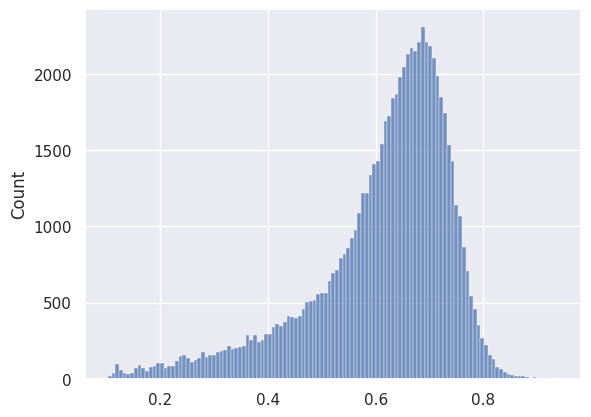

In [52]:
sns.histplot(weights)

#### 1.2.2 Histograma de degree dos vertices

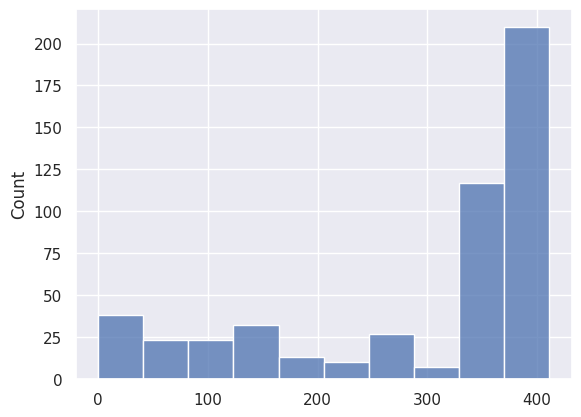

In [58]:
data = gt_data(g)
degrees = pd.Series([v.total_degree() for v in g.all_vertices()])

sns.histplot(degrees);

## 2.  Regressão dos dados da rede


In [124]:
sample["clustering"] = pd.Series(clustering.local_clustering(g), index=sample.index)
sample

,rating,language,genres,clustering
36767,0.840,English,"[Vampires, Young Adult, Paranormal, Fantasy, R...",0.912770
22655,1.000,English,[],0.000000
17353,0.782,English,"[Fiction, Short Stories, Classics, Literature,...",0.890316
39249,0.802,Italian,"[Science Fiction, France, Adventure]",0.919613
4814,0.810,English,"[Fiction, Thriller, Military Fiction, Espionag...",0.945678
...,...,...,...,...
4063,0.758,English,"[Science Fiction, Fiction, Fantasy, Science Fi...",0.887546
13018,0.850,English,"[Romantic Suspense, Romance, Thriller, Crime, ...",0.891834
24993,0.720,English,"[Historical Fiction, Fiction, Asia, Historical...",0.936555
25873,0.924,English,"[Romance, Christian]",0.949986


In [125]:
result = reg.linear(data=sample, formula='rating ~ clustering + language')

result.micro_summary()

variable,coefficient,std error,p-value
language[T.Albanian],-0.000000,0.000000,0.000006
language[T.Aleut],0.000000,0.000000,0.006131
language[T.Amharic],-0.000000,0.000000,0.000437
language[T.Arabic],0.010530,0.021180,0.619326
language[T.Armenian],0.000000,0.000000,0.673387
language[T.Aromanian; Arumanian; Macedo-Romanian],-0.000000,0.000000,0.834657
language[T.Assamese],-0.000000,0.000000,0.018122
language[T.Australian languages],-0.000000,0.000000,0.519418
language[T.Azerbaijani],0.000000,0.000000,0.117890
language[T.Basque],0.000000,0.000000,0.079718


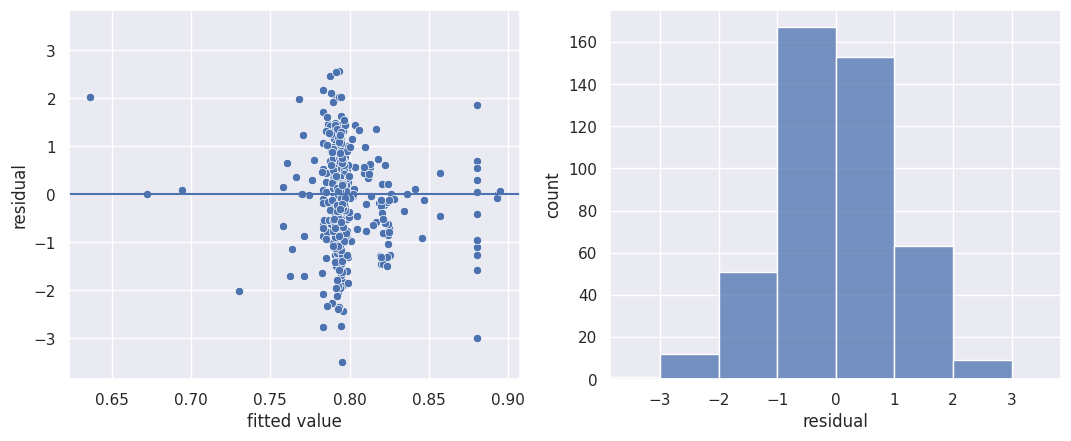

In [127]:
result.plot_residuals()

### 1.3. Limpeza da rede

In [ ]:
hcc = centrality.closeness(g, harmonic=True)
hcc

In [ ]:
m = gt_draw.sfdp_layout(g)

gt_move(g, m)
gt_save(g, 'best-books-ever.net.gz')

In [ ]:
r = netpixi.render('best-books-ever.net.gz', infinite=True);

In [ ]:
r.edge_scale('weight', 1, 10)
r.vertex_scale('rating', 5, 20)